# Extracting Parameters From Sensor Data and Creating Parameter Dataframe

In [15]:
# import h5py # needs conda/pip install h5py
# import os
# os.chdir(r'C:\Users\jared\OneDrive\Documents\School\Thesis')

import sys
sys.path.append(r'C:\users\jared\anaconda3\lib\site-packages')
# import command_file

import matplotlib.pyplot as plt
import pandas as pd
import spear as sp
import numpy as np
from pathlib import Path  
import time

DATA_PATH    = 'D:\SEVIR Data\data'
CATALOG_PATH = 'D:\SEVIR Data/CATALOG.csv'

# Read catalog
catalog = pd.read_csv(CATALOG_PATH,parse_dates=['time_utc'],low_memory=False)

# Desired image types
img_types = set(['vil'])

# Group by event id, and filter to only events that have all desired img_types
events = catalog.groupby('id').filter(lambda x: img_types.issubset(set(x['img_type']))).groupby('id')
event_ids = list(events.groups.keys())
print('Found %d events matching' % len(event_ids),img_types)

Found 20273 events matching {'vil'}


### Construct DataFrame for Storage

In [1]:
threshold = 100
df_ignored = []

start_time = time.time()

features = ['EventID', 
            'FileName',
            'SemiMajorAxisLength', 
            'SemiMinorAxisLength', 
            'EllipseAngle', 
            'COMX', 
            'COMY', 
            'Average',
            'Intensity',
            'VelocityX',
            'VelocityY',
            'AngularVelocity']
flag = True



for event_index in range(0, len(event_ids)):
# for event_index in range(5, 7):
    sample_event = events.get_group(event_ids[event_index])
    if(sample_event.size > 21):
        sample_event = sample_event.loc[sample_event['img_type'] == 'vil']
        if(sample_event.size > 21):
            sample_event = pd.DataFrame(sample_event.iloc[0,:])
            sample_event = sample_event.T
    event_Number = event_ids[event_index]
    # print(sample_event)
    percent_missing = sample_event.loc[:,'pct_missing'].item()
    print(event_index, event_Number, percent_missing)
    
    if percent_missing > 30:
        df_ignored.append([event_Number, file_name])
        flag = False
        
    file_name = sample_event.loc[:,'file_name'].item()
    # print(sample_event.head())
    vil = sp.read_data(sample_event, 'vil')
    parameterVector = []

    if flag:
        for frame in range(0, vil.shape[2]):
            image = vil[:,:,frame]
            # missingness = sp.checkMissingness(image)
            # print(percentMissing, missingness)
            # if (missingness > 0.33):
            #     flag = False
            #     break
            try:
                major, minor, angle, com, average, intensity = sp.findStormParams(image, threshold)
            except:
                df_ignored.append([event_Number, file_name])
                # print('This file not valid')
                flag = False
                break
                
            comX = com[0]
            comY = com[1]
            
            params = [event_Number, file_name, major, minor, angle, comX, comY, average, intensity, 0.0, 0.0, 0.0]
            parameterVector.append(params)

    if flag:
        df = pd.DataFrame(parameterVector, columns = features)
        velocityX = sp.findCOMVelocity(df.loc[:,'COMX'])
        velocityY = sp.findCOMVelocity(df.loc[:,'COMY'])
        angularVelocity = sp.findAngularVelocity(df.loc[:,'EllipseAngle'])
        df.loc[0:47,'VelocityX'] = velocityX
        df.loc[0:47,'VelocityY'] = velocityY
        df.loc[0:47,'AngularVelocity'] = angularVelocity        
        
        paramFileName = event_Number + '_Params.csv'
        filepath = Path('D:\Extracted Data', paramFileName)  
        # filepath.parent.mkdir(parents=True, exist_ok=True)  
        # df.to_csv(filepath, index=False)
    flag = True
print("--- %s seconds ---" % (time.time() - start_time))

NameError: name 'time' is not defined

In [3]:
len(df_ignored)

5316

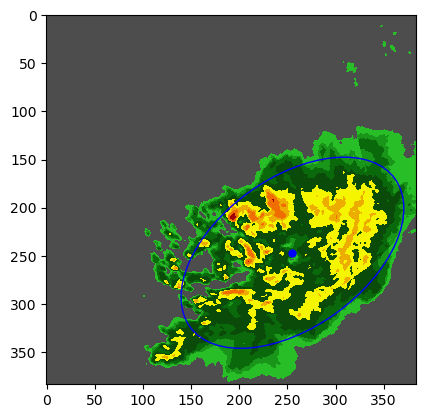

In [4]:
from matplotlib.patches import Ellipse
from display import get_cmap

i = 40

im = vil[:,:,i]
major = df.iloc[i,2]
minor = df.iloc[i,3]
an = df.iloc[i,4]
x = df.iloc[i,5]
y = df.iloc[i,6]

vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)
plt.imshow(im,cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax)
ax = plt.gca()
ell = Ellipse(xy=(y, x), 
              width= major*2, 
              height= minor*2,
              angle= an)
ell.set_facecolor('none')
ell.set_edgecolor('violet')
ax.add_artist(ell)
plt.plot(y,x, "ob", markersize=5)

In [5]:
filepath = Path('D:\Extracted Data\ignored_events.csv')
df_ignored = pd.DataFrame(df_ignored)
df_ignored.columns = ['event_id', 'file_name']
df_ignored.head()

,event_id,file_name
0,R17061411227811,vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5
1,R17061411227912,vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5
2,R17061415277461,vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5
3,R17061415277774,vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5
4,R17061418507777,vil/2017/SEVIR_VIL_RANDOMEVENTS_2017_0501_0831.h5


In [6]:
df_ignored.to_csv(filepath, index=False)

Weird Indices:
    66 - Double vil entry
    4324 - ???

In [12]:
df_ignored.size / 2

5316.0

In [8]:
df = pd.read_csv('D:\Extracted Data/R17061402258162_Params.csv')
# df.head()